In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Data Preperation

## Loading Dataset

Dataset is split into **"train"** and **"val"**, which are used directly to avoid the need of *random_split*

In [2]:
from torchvision.datasets import ImageFolder


data_dir = "../data"
train_dir = "../data/train"
val_dir = "../data/val"

# Load train and val datasets separately
train_dataset_base = ImageFolder(root=train_dir, transform=None)
val_dataset_base = ImageFolder(root=val_dir, transform=None)

# Get classes from training set
classes = train_dataset_base.classes
num_classes = len(classes)

print("Classes:", classes)
print("Number of training images:", len(train_dataset_base))
print("Number of validation images:", len(val_dataset_base))


Classes: ['citrus_black_spot', 'citrus_canker', 'citrus_foliage_damage', 'citrus_greening', 'citrus_healthy', 'citrus_mealybugs', 'citrus_melanose', 'mango_anthracnose', 'mango_bacterial_canker', 'mango_cutting_weevil', 'mango_die_back', 'mango_gall_midge', 'mango_healthy', 'mango_powdery_mildew', 'mango_sooty_mould']
Number of training images: 24499
Number of validation images: 6127


Distribution of Training Dataset

In [3]:
from collections import Counter

# Class distribution 
train_labels = [label for _, label in train_dataset_base.imgs]
class_counts = Counter(train_labels)

print("\nTraining class distribution:")
for cls_idx, count in class_counts.items():
    print(f"{classes[cls_idx]:35s}: {count}")



Training class distribution:
citrus_black_spot                  : 136
citrus_canker                      : 8998
citrus_foliage_damage              : 1680
citrus_greening                    : 163
citrus_healthy                     : 5107
citrus_mealybugs                   : 3135
citrus_melanose                    : 2080
mango_anthracnose                  : 400
mango_bacterial_canker             : 400
mango_cutting_weevil               : 400
mango_die_back                     : 400
mango_gall_midge                   : 400
mango_healthy                      : 400
mango_powdery_mildew               : 400
mango_sooty_mould                  : 400


Defining Rare Classes (Less than 200 instances)

In [4]:
RARE_THRESHOLD = 200

rare_classes = {
    cls_idx for cls_idx, count in class_counts.items()
    if count < RARE_THRESHOLD
}

print("\nRare classes:")
for cls_idx in rare_classes:
    print(classes[cls_idx])


Rare classes:
citrus_black_spot
citrus_greening


`This shows the massive imbalance in class count, making it clear that we need to address it.`

### Handling Class Imbalance
In order to handle class imbalance, we use different transforms depending on the size of the class that's applied to.<br>
This makes all classes contribute similarly to the prediction and avoids bias.

In [5]:

from torchvision import transforms

light_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

strong_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
        hue=0.1
    ),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        scale=(0.9, 1.1)
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [6]:
from torch.utils.data import Dataset

class ClassAwareDataset(Dataset):
    def __init__(self, base_dataset, rare_classes,
                 light_transform, strong_transform):
        self.base_dataset = base_dataset
        self.rare_classes = rare_classes
        self.light_transform = light_transform
        self.strong_transform = strong_transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        path, label = self.base_dataset.samples[idx]
        img = self.base_dataset.loader(path)  # ALWAYS PIL Image

        if label in self.rare_classes:
            img = self.strong_transform(img)
        else:
            img = self.light_transform(img)

        return img, label

In [7]:
# Class-aware training dataset
train_dataset = ClassAwareDataset(
    train_dataset_base,
    rare_classes,
    light_transform,
    strong_transform
)

# Validation dataset with val_transform
val_dataset = ImageFolder(root=val_dir, transform=val_transform)

In [8]:
from torch.utils.data import WeightedRandomSampler

class_weights = np.zeros(num_classes)
for cls_idx, count in class_counts.items():
    class_weights[cls_idx] = 1.0 / count

class_weights = class_weights / class_weights.sum()

sample_weights = [
    class_weights[label] for label in train_labels
]

sample_weights = torch.DoubleTensor(sample_weights)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

## Creating Dataloaders

In [9]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,  # Avoids Learning order bias
    num_workers=0,  # Used for faster loading, yet for windows it makes training take forever. Therefore we use 0
    pin_memory=True  # For faster GPU transfer
)

In [10]:
import os

print("\nTraining set class counts:")
for idx, class_name in enumerate(classes):
    class_path = os.path.join(train_dir, class_name)
    count = len(os.listdir(class_path)) if os.path.isdir(class_path) else 0
    print(f"{class_name:35} : {count:5d}")

print("\nValidation set class counts:")
for idx, class_name in enumerate(classes):
    class_path = os.path.join(val_dir, class_name)
    count = len(os.listdir(class_path)) if os.path.isdir(class_path) else 0
    print(f"{class_name:35} : {count:5d}")


Training set class counts:
citrus_black_spot                   :   136
citrus_canker                       :  8998
citrus_foliage_damage               :  1680
citrus_greening                     :   163
citrus_healthy                      :  5107
citrus_mealybugs                    :  3135
citrus_melanose                     :  2080
mango_anthracnose                   :   400
mango_bacterial_canker              :   400
mango_cutting_weevil                :   400
mango_die_back                      :   400
mango_gall_midge                    :   400
mango_healthy                       :   400
mango_powdery_mildew                :   400
mango_sooty_mould                   :   400

Validation set class counts:
citrus_black_spot                   :    35
citrus_canker                       :  2250
citrus_foliage_damage               :   420
citrus_greening                     :    41
citrus_healthy                      :  1277
citrus_mealybugs                    :   784
citrus_melanose   

# Modeling

### Model Definition

Using ResNet18 as backbone, implementing transfer learning that helps our model to start out strong with already learned features, and minimizing needed training for reaching an optimal solution.

In [11]:
from torchvision import models
import torch.nn as nn

def get_model(num_classes):
    model = models.resnet18(weights="IMAGENET1K_V1")

    # Freeze feature extractor
    for param in model.parameters():
        param.requires_grad = False

    for param in model.fc.parameters():
        param.requires_grad = True
    
    # Replace classifier
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

### Evaluation Function

In [12]:

from sklearn.metrics import classification_report, confusion_matrix

def evaluate(model, dataloader, device):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

### Early Stoppage

In [13]:
# Early stopping class (assuming it's defined elsewhere in your project)
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False


### Model Training

In [14]:

import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes).to(device)

# Compute class weights (inverse frequency) from training data
class_counts_array = np.bincount(train_labels)
weights = 1.0 / (class_counts_array + 1e-6)
weights = torch.tensor(weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam([
    {'params': model.fc.parameters(), 'lr': 1e-3},        # head (fast)
    {'params': model.layer4.parameters(), 'lr': 1e-4}     # backbone (slow)
])

early_stopping = EarlyStopping(patience=5, min_delta=0.001, verbose=True)

num_epochs = 15
best_val_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "../models/ResNet18_model.pth")
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # Early stopping check
    if early_stopping(val_loss):
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.4f}")

Epoch 1/15 | Train Loss: 0.4768 | Train Acc: 0.8074 | Val Loss: 0.4031 | Val Acc: 0.8786
Epoch 2/15 | Train Loss: 0.2002 | Train Acc: 0.9328 | Val Loss: 0.2520 | Val Acc: 0.9150
Epoch 3/15 | Train Loss: 0.1781 | Train Acc: 0.9423 | Val Loss: 0.1827 | Val Acc: 0.9391
Epoch 4/15 | Train Loss: 0.1557 | Train Acc: 0.9486 | Val Loss: 0.1599 | Val Acc: 0.9448
Epoch 5/15 | Train Loss: 0.1570 | Train Acc: 0.9511 | Val Loss: 0.1266 | Val Acc: 0.9550
Epoch 6/15 | Train Loss: 0.1482 | Train Acc: 0.9521 | Val Loss: 0.1260 | Val Acc: 0.9581
EarlyStopping counter: 1/5
Epoch 7/15 | Train Loss: 0.1432 | Train Acc: 0.9542 | Val Loss: 0.1224 | Val Acc: 0.9541
Epoch 8/15 | Train Loss: 0.1416 | Train Acc: 0.9561 | Val Loss: 0.1062 | Val Acc: 0.9610
Epoch 9/15 | Train Loss: 0.1395 | Train Acc: 0.9564 | Val Loss: 0.1110 | Val Acc: 0.9572
EarlyStopping counter: 1/5
Epoch 10/15 | Train Loss: 0.1334 | Train Acc: 0.9546 | Val Loss: 0.0934 | Val Acc: 0.9644
Epoch 11/15 | Train Loss: 0.1381 | Train Acc: 0.9575 | 

### Visualizing Accuracy and Loss

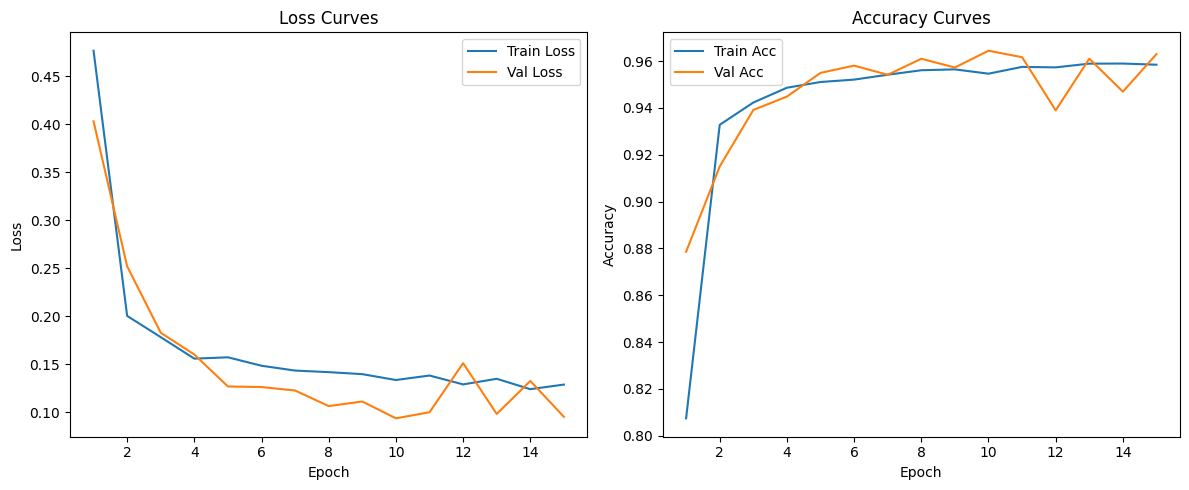

In [15]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.show()

`Since we have a case of "class imbalance", accuracy isn't enough to evaluate out model.`<br>
`F1-Score, Recall & Precision are or reliable metrics which we'll use.`

              precision    recall  f1-score   support

           0       0.80      0.94      0.87        35
           1       0.99      0.99      0.99      2250
           2       0.81      0.78      0.79       420
           3       0.97      0.78      0.86        41
           4       0.99      0.98      0.99      1277
           5       0.88      0.90      0.89       784
           6       1.00      1.00      1.00       520
           7       1.00      1.00      1.00       100
           8       1.00      0.99      0.99       100
           9       1.00      1.00      1.00       100
          10       1.00      1.00      1.00       100
          11       0.98      1.00      0.99       100
          12       1.00      1.00      1.00       100
          13       1.00      1.00      1.00       100
          14       0.96      1.00      0.98       100

    accuracy                           0.96      6127
   macro avg       0.96      0.96      0.96      6127
weighted avg       0.96   

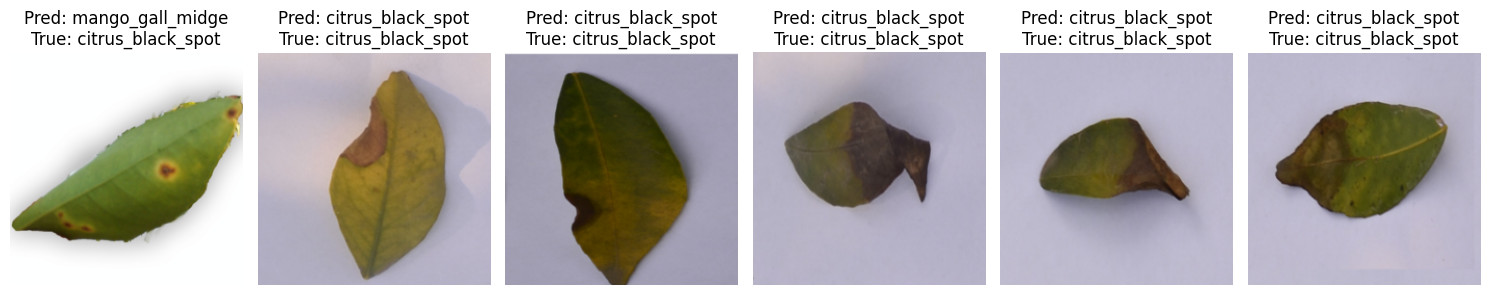

In [16]:
# Load model
model.load_state_dict(torch.load("../models/ResNet18_model.pth"))
model.eval()
evaluate(model, val_loader, device)  # Classification report and confusion matrix

import random

def show_sample_predictions(model, dataloader, class_names, device, num_samples=6):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 5))
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            for i in range(images.size(0)):
                if images_shown >= num_samples:
                    break
                img = images[i].cpu().numpy().transpose(1,2,0)
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = np.clip(img, 0, 1)
                plt.subplot(1, num_samples, images_shown+1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
                images_shown += 1
            if images_shown >= num_samples:
                break
    plt.tight_layout()
    plt.show()

# Show predictions on validation set
show_sample_predictions(model, val_loader, classes, device)